#  TP2: Regresión del valor de valor medio de casas en distritos de California

**Autor**
Niels Victor Pacheco Barrios
 
Se requiere construir una regresión que nos permita predecir el valor medio de las casas en distritos de California, EEUU (medidos en cientos de miles de dólares $100,000). Este dataset se deriva del censo de 1990 de EEUU, donde cada observación es un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EEUU publica datos de muestra (un bloque típicamente tiene una población de 600 a 3000 personas).

Los atributos, en el orden en que se guardaron en el dataset, son:

MedInc: Ingreso medio en el bloque
HouseAge: Edad mediana de las casas en el bloque
AveRooms: Número promedio de habitaciones por hogar.
AveBedrms: Número promedio de dormitorios por hogar.
Population: Población del bloque
AveOccup: Número promedio de miembros por hogar.
Latitude: Latitud del bloque
Longitude: Longitud del bloque
Y el target es:

MedHouseVal: Mediana del costo de casas en el bloque (en unidades de a $100.000)

## Tareas y preguntas a resolver:

1. Obtener la correlación entre los atributos y los atributos con el target. ¿Cuál atributo tiene mayor correlación lineal con el target y cuáles atributos parecen estar más correlacionados entre sí? Se puede obtener los valores o directamente graficar usando un mapa de calor.

2. Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma de histograma se observa? ¿Se observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin entrar en pruebas de hipótesis?

3. Calcular la regresión lineal usando todos los atributos. Con el set de entrenamiento, calcular la varianza total del modelo y la que es explicada con el modelo. ¿El modelo está capturando el comportamiento del target? Expanda su respuesta.

4. Calcular las métricas de MSE, MAE y R2 del set de evaluación.

5. Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de α, buscando entre [0, 12.5]. Graficar el valor de MSE versus α

6. Comparar, entre la regresión lineal y la mejor regresión de Ridge, los resultados obtenidos en el set de evaluación. ¿Cuál da mejores resultados (usando MSE y MAE)? Conjeturar por qué el mejor modelo mejora. ¿Qué error puede haberse reducido?

7. El entregable consiste en uno o más archivos de notebook ipynb con las respuestas. Aunque se da libertad para usar otros tipos de entregables, es importante incluir tanto el código de lo resuelto como las respuestas. Pueden subir el contenido o proporcionar un enlace a un repositorio público (GitHub o GitLab) con el contenido. No olviden especificar los autores del TP en el entregable.

Para resolver este TP, son libres de utilizar los recursos que consideren necesarios. Pueden hacerlo en cualquier lenguaje de programación y de la forma que consideren apropiada.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge

sns.set()


In [16]:
# Leemos el dataset
california_housing = fetch_california_housing()

# Y obtenemos los atributos y target
X = california_housing.data
y = california_housing.target

# Transformamos en Pandas
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Unimos a X e y, esto ayuda a la parte de la gráfica del mapa de calor de correlación
df_california = pd.concat([X, y], axis=1)

In [17]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [25]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [18]:
df_california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Hacemos limpieza de datos

Eliminamos los valores outliers del dataset

In [22]:
from scipy import stats
import numpy as np

# Detectar y filtrar outliers en 'AveRooms' utilizando el Z-Score
z_scores = np.abs(stats.zscore(df_california['AveRooms']))
threshold = 3
df_california = df_california[z_scores < threshold]

# Detectar y filtrar outliers en 'AveBedrms' utilizando el Z-Score
z_scores = np.abs(stats.zscore(df_california['AveBedrms']))
df_california = df_california[z_scores < threshold]

# Detectar y filtrar outliers en 'MedHouseVal' utilizando el IQR
Q1 = df_california['MedHouseVal'].quantile(0.25)
Q3 = df_california['MedHouseVal'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los outliers
df_california = df_california[(df_california['MedHouseVal'] >= lower_bound) & (df_california['MedHouseVal'] <= upper_bound)]

# Mostrar la forma original y la nueva forma del DataFrame
print(f"Forma original del dataset: {california_housing.data.shape}")
print(f"Forma del dataset sin outliers: {df_california.shape}")

Forma original del dataset: (20640, 8)
Forma del dataset sin outliers: (19103, 9)


In [24]:
df_california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 1. Obtener la correlación entre los atributos y con el target

MedInc        0.646744
HouseAge      0.057953
AveRooms      0.281372
AveBedrms    -0.111178
Population    0.007096
AveOccup     -0.021778
Latitude     -0.142963
Longitude    -0.047963
Name: MedHouseVal, dtype: float64


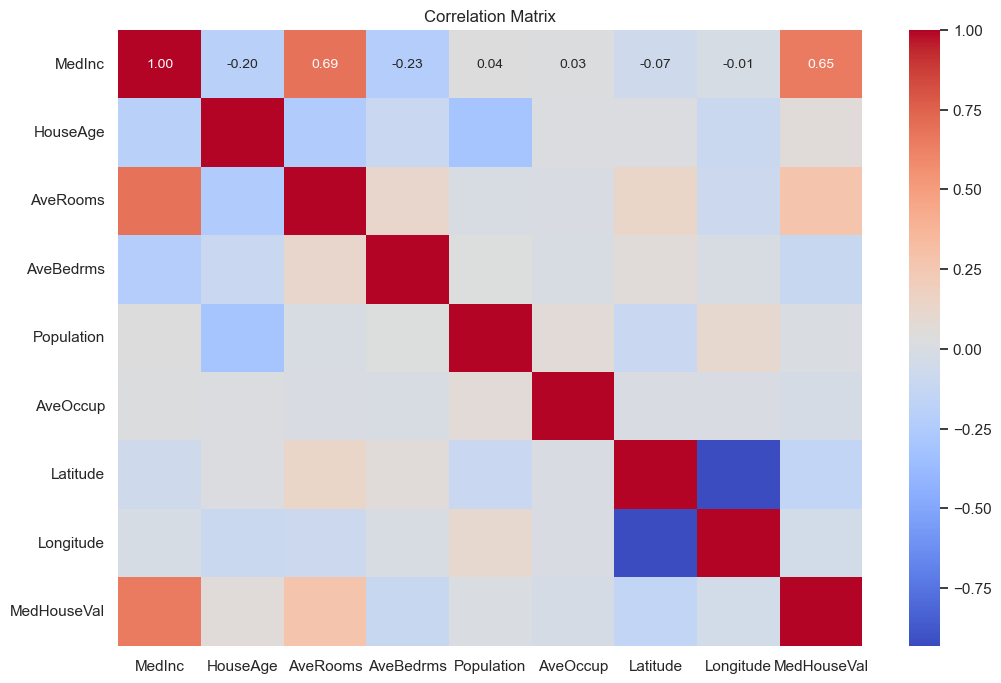

In [26]:

# Calcular la matriz de correlación
california_correlation = df_california.corr()

# Obtener la correlación de los atributos con el target
california_correlation_with_target = california_correlation['MedHouseVal'].drop('MedHouseVal')

# Imprimir la correlación de los atributos con el target
print(california_correlation_with_target)

# Graficar el mapa de calor de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(california_correlation, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

* *Del la lectura del mapa de calor, se observa que el atributo con mayor correlación con el target (MedHouseVale), es MedInc. A su vez, AveRooms y AveBedrms con correlaciones debiles (r menores a 0.5).*

## 2. Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma de histograma se observa? ¿Se observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin entrar en pruebas de hipótesis?

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

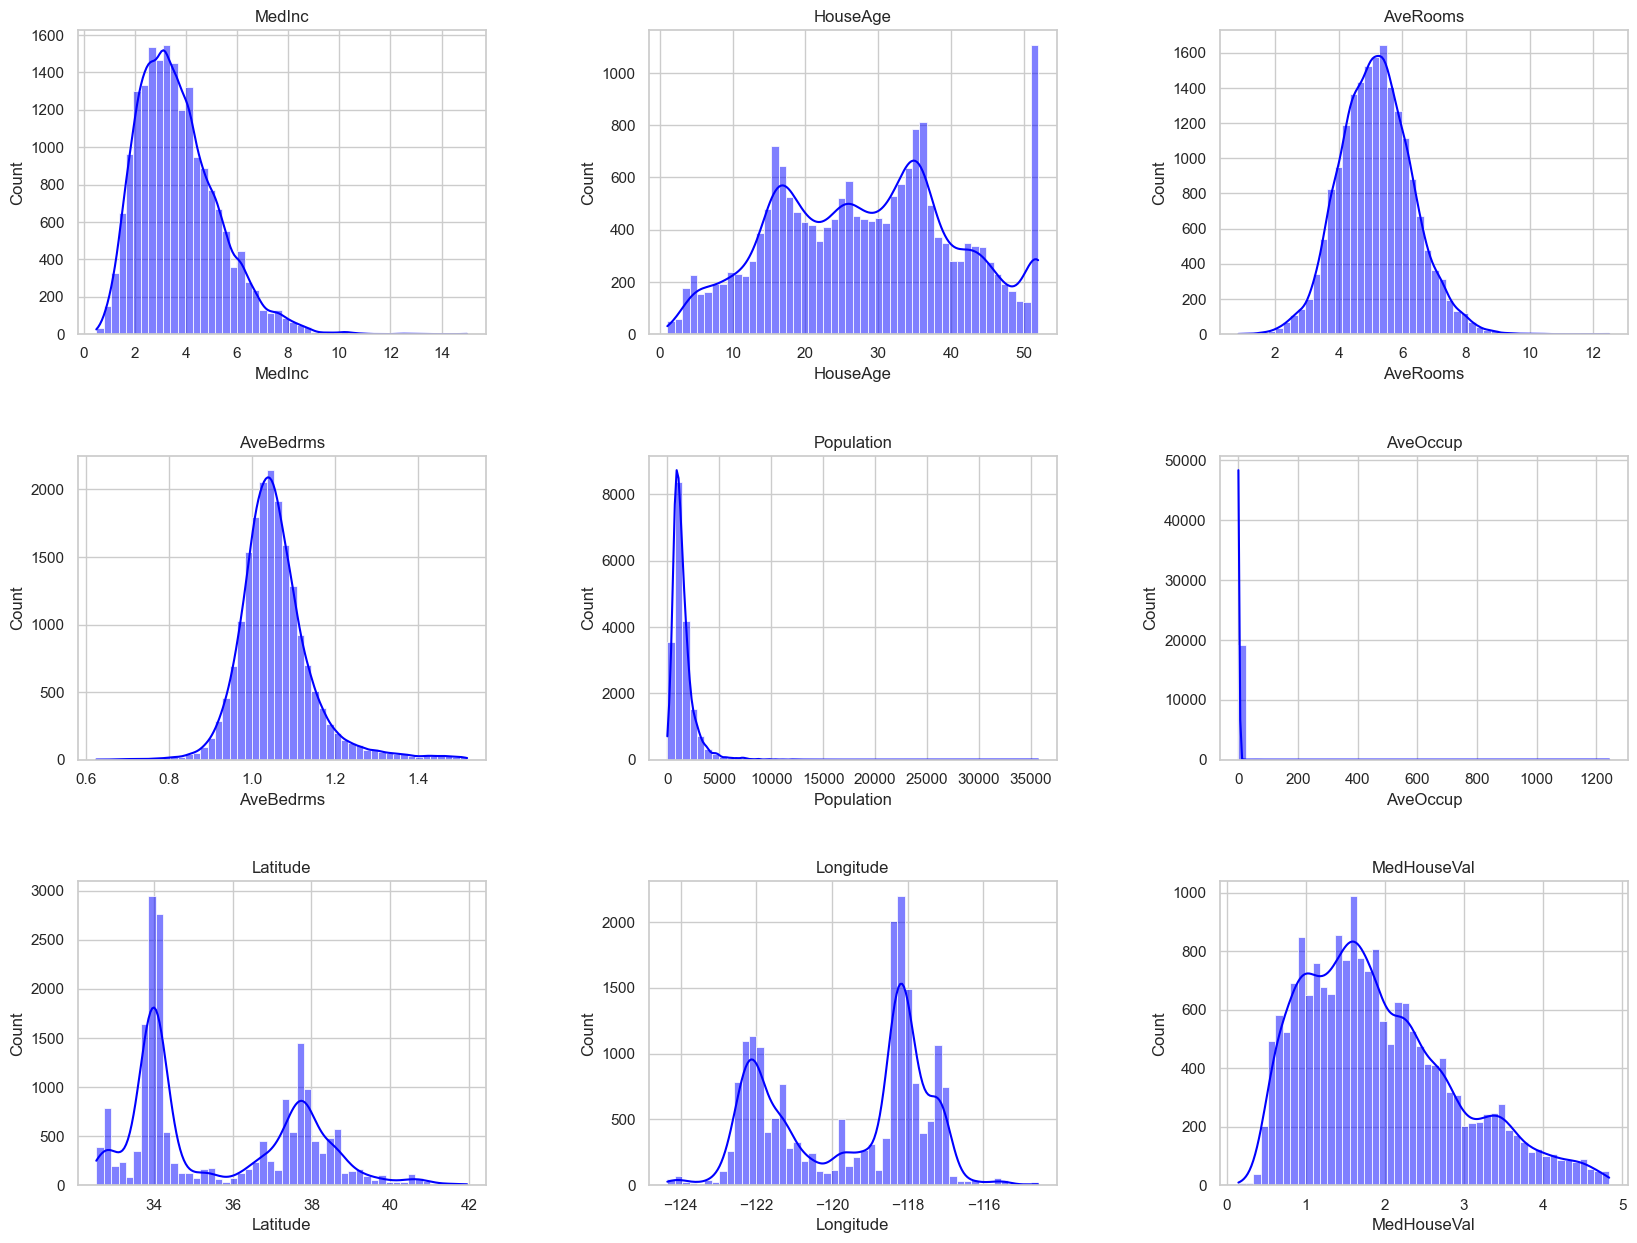

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de seaborn
sns.set(style="whitegrid")

# Graficar los histogramas y las curvas de densidad para los diferentes atributos y el target
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

columns = df_california.columns
for i, ax in enumerate(axes.flat):
    if i < len(columns):
        sns.histplot(df_california[columns[i]], kde=True, ax=ax, bins=50, color='blue')
        ax.set_title(columns[i])

plt.show()



* *Las variables MedInc, AveRooms, AveBedrms, AveOccup, Population se observa la forma de campana por lo tanto los datos podrían provenir de una distribución normal o gaussiana.*

## 3.Calcular la regresión lineal usando todos los atributos. Con el set de entrenamiento, calcular la varianza total del modelo y la que es explicada con el modelo. ¿El modelo está capturando el comportamiento del target? Expanda su respuesta.

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [35]:
# Separar los atributos y el target
X = df_california.drop('MedHouseVal', axis=1)
y = df_california['MedHouseVal']

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear y entrenar el modelo de regresión lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predecir los valores de entrenamiento
y_train_pred = lin_reg.predict(X_train)

# Calcular la varianza total y la varianza explicada
total_variance = np.var(y_train)
explained_variance = np.var(y_train_pred)

print(f'Total Variance: {total_variance}')
print(f'Explained Variance: {explained_variance}')

# Evaluar el modelo con el set de prueba
y_test_pred = lin_reg.predict(X_test)
r2 = r2_score(y_test, y_test_pred)

print(f'R2 Score: {r2}')

# Comentar sobre el comportamiento del modelo
if r2 > 0.5:
    print("El modelo está capturando un comportamiento significativo del target.")
else:
    print("El modelo no está capturando adecuadamente el comportamiento del target.")


Total Variance: 0.8995399248254925
Explained Variance: 0.5350784662909895
R2 Score: 0.5837017625492058
El modelo está capturando un comportamiento significativo del target.


* *El modelo, en base al R2, esta capturando el comportamiento del target, sin embargo es necesario calcular medidas adicionales para tener una conclusión mas robusta*

## 4. Calcular las métricas de MSE, MAE y R2 del set de evaluación.

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluar el modelo con el set de prueba
y_test_pred = lin_reg.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R2 Score: {r2}')


Mean Squared Error (MSE): 0.396546312070467
Mean Absolute Error (MAE): 0.4675449177336181
R2 Score: 0.5837017625492058


## 5.Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de α, buscando entre [0, 12.5]. Graficar el valor de MSE versus α

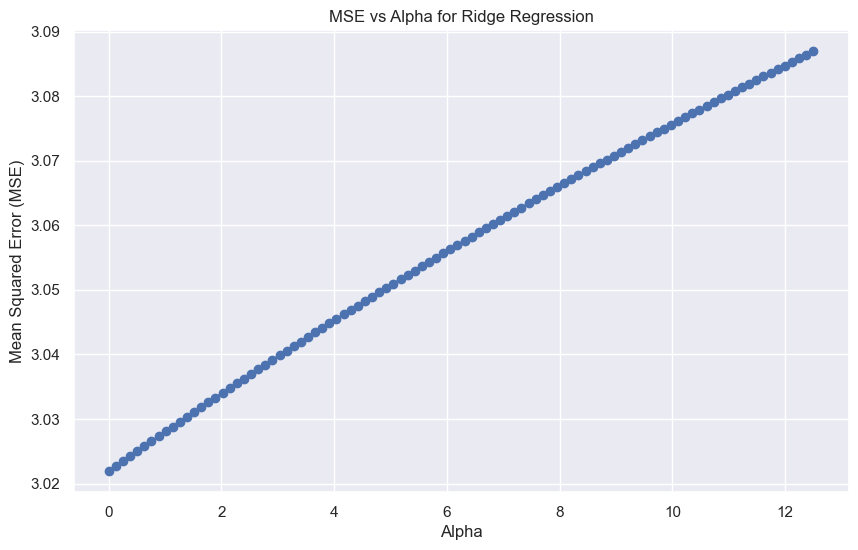

Best Alpha: 0.0


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Definir el rango de valores de alpha
alpha_values = np.linspace(0, 12.5, 100)

# Lista para almacenar los resultados de MSE para cada alpha
mse_values = []

# Realizar validación cruzada de 5-folds para cada valor de alpha
for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    mse = -cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    mse_values.append(mse)

# Graficar el valor de MSE versus alpha
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, mse_values, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Alpha for Ridge Regression')
plt.grid(True)
plt.show()

# Obtener el mejor valor de alpha
best_alpha = alpha_values[np.argmin(mse_values)]
print(f'Best Alpha: {best_alpha}')


*El mejor valor de alfa es 0, es decir no requiere ajuste*

## 6.Comparar, entre la regresión lineal y la mejor regresión de Ridge, los resultados obtenidos en el set de evaluación. ¿Cuál da mejores resultados (usando MSE y MAE)? Conjeturar por qué el mejor modelo mejora. ¿Qué error puede haberse reducido?

In [44]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluar el modelo de regresión lineal en el set de prueba
y_test_pred_lin = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_test_pred_lin)
mae_lin = mean_absolute_error(y_test, y_test_pred_lin)

# Crear y entrenar el modelo de regresión Ridge con el mejor alpha
best_ridge_model = Ridge(alpha=best_alpha_fine)
best_ridge_model.fit(X_train, y_train)

# Evaluar el modelo de regresión Ridge en el set de prueba
y_test_pred_ridge = best_ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)

# Imprimir los resultados
print(f'Resultados de la regresión lineal:')
print(f'Mean Squared Error (MSE): {mse_lin}')
print(f'Mean Absolute Error (MAE): {mae_lin}')
print()
print(f'Resultados de la regresión Ridge (alpha={best_alpha_fine}):')
print(f'Mean Squared Error (MSE): {mse_ridge}')
print(f'Mean Absolute Error (MAE): {mae_ridge}')


Resultados de la regresión lineal:
Mean Squared Error (MSE): 0.396546312070467
Mean Absolute Error (MAE): 0.4675449177336181

Resultados de la regresión Ridge (alpha=0.0):
Mean Squared Error (MSE): 0.3965463120704672
Mean Absolute Error (MAE): 0.46754491773361795


* *Debido a que el alfa es 0, la regresión de rigde equivale a no aplicar ninguna regularización, por lo que decimos que los resultados son identicos*
*  *Algunas posibles razones de porque la regresion de ridge no esta haciendo ningun ajuste es por que los datos pueden estar ya bien ajustados en la regresión lineal. Esto puede ocurrir si no hay mucho ruido o la dimensionalidad del problema no es muy alta para requerir una regularización. Otra razón es que haya una baja colinearidad, pues la regresión ridge es util cuando la colinealidad es alta. Otro problema esta en que al buscar el rango de alfa, a pesar de buscar un rango amplio, es posible que los datos de este problema no necesiten regularización, especialmente debido a la eliminación de los outliers.*

### Buscamos cual es la diferencia entre la regresion lineal y la de ridge si no hubiesemos eliminado los outliers

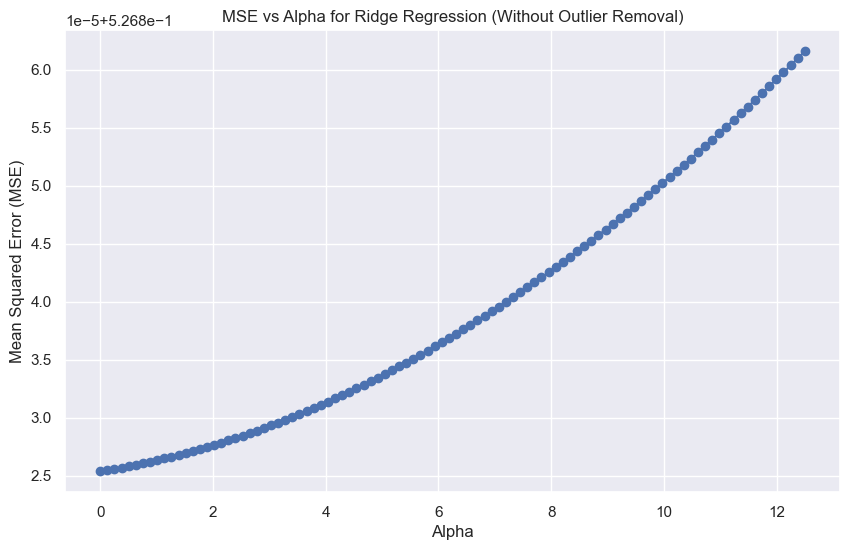

Best Alpha without outlier removal: 0.0
Resultados de la regresión lineal (sin limpieza de outliers):
Mean Squared Error (MSE): 0.530567782476675
Mean Absolute Error (MAE): 0.527247453830597

Resultados de la regresión Ridge (alpha=0.0 sin limpieza de outliers):
Mean Squared Error (MSE): 0.5305677824766752
Mean Absolute Error (MAE): 0.5272474538305951


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from sklearn.datasets import fetch_california_housing

# Cargar los datos originales sin limpieza de outliers
california_housing = fetch_california_housing()
X = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
y = pd.Series(california_housing.target, name=california_housing.target_names[0])

# Dividir el dataset en conjunto de entrenamiento y prueba sin limpiar outliers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definir el rango de valores de alpha
alpha_values = np.linspace(0, 12.5, 100)

# Lista para almacenar los resultados de MSE para cada alpha
mse_values = []

# Realizar validación cruzada de 5-folds para cada valor de alpha
for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    mse = -cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    mse_values.append(mse)

# Graficar el valor de MSE versus alpha
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, mse_values, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Alpha for Ridge Regression (Without Outlier Removal)')
plt.grid(True)
plt.show()

# Obtener el mejor valor de alpha
best_alpha = alpha_values[np.argmin(mse_values)]
print(f'Best Alpha without outlier removal: {best_alpha}')

# Crear y entrenar el modelo de regresión Ridge con el mejor alpha
best_ridge_model = Ridge(alpha=best_alpha)
best_ridge_model.fit(X_train, y_train)

# Evaluar el modelo de regresión Ridge en el set de prueba
y_test_pred_ridge = best_ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)

# Evaluar el modelo de regresión lineal en el set de prueba
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_test_pred_lin = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_test_pred_lin)
mae_lin = mean_absolute_error(y_test, y_test_pred_lin)

# Imprimir los resultados
print(f'Resultados de la regresión lineal (sin limpieza de outliers):')
print(f'Mean Squared Error (MSE): {mse_lin}')
print(f'Mean Absolute Error (MAE): {mae_lin}')
print()
print(f'Resultados de la regresión Ridge (alpha={best_alpha} sin limpieza de outliers):')
print(f'Mean Squared Error (MSE): {mse_ridge}')
print(f'Mean Absolute Error (MAE): {mae_ridge}')





*A pesar de mantener los outliers, el alfa sigue siendo 0 y la regresión de ridge no aporta ningun beneficio. Concluimos que, en el caso de esta base de datos, los outliers no tienen gran importancia para determinar el valor de alfa*

### Ahora probaremos si escalamos los datos, habra alguna diferencia entre la regresion lineal y Ridge?

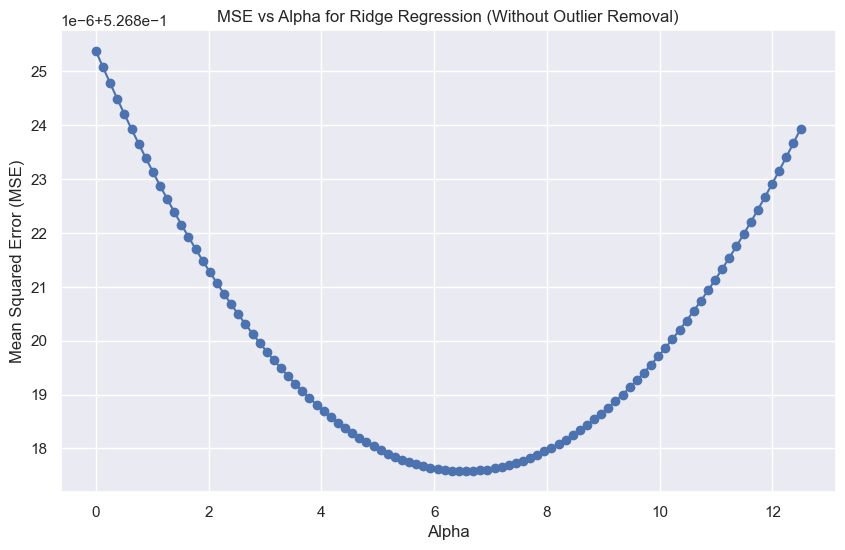

Best Alpha without outlier removal: 6.565656565656566
Resultados de la regresión lineal (sin limpieza de outliers):
Mean Squared Error (MSE): 0.5305677824766755
Mean Absolute Error (MAE): 0.5272474538305956

Resultados de la regresión Ridge (alpha=6.565656565656566 sin limpieza de outliers):
Mean Squared Error (MSE): 0.5304149219232502
Mean Absolute Error (MAE): 0.5272217082364


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

# Cargar los datos originales sin limpieza de outliers
california_housing = fetch_california_housing()
X = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
y = pd.Series(california_housing.target, name=california_housing.target_names[0])

# Dividir el dataset en conjunto de entrenamiento y prueba sin limpiar outliers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalado de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Realizar validación cruzada de 5-folds para diferentes valores de alpha en datos escalados
alpha_values = np.linspace(0, 12.5, 100)
mse_values = []

for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    mse = -cross_val_score(ridge_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    mse_values.append(mse)

# Graficar el valor de MSE versus alpha
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, mse_values, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Alpha for Ridge Regression (Without Outlier Removal)')
plt.grid(True)
plt.show()

# Obtener el mejor valor de alpha
best_alpha = alpha_values[np.argmin(mse_values)]
print(f'Best Alpha without outlier removal: {best_alpha}')

# Crear y entrenar el modelo de regresión Ridge con el mejor alpha en datos escalados
best_ridge_model = Ridge(alpha=best_alpha)
best_ridge_model.fit(X_train_scaled, y_train)

# Evaluar el modelo de regresión Ridge en el set de prueba escalado
y_test_pred_ridge = best_ridge_model.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)

# Evaluar el modelo de regresión lineal en el set de prueba escalado
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_test_pred_lin = lin_reg.predict(X_test_scaled)
mse_lin = mean_squared_error(y_test, y_test_pred_lin)
mae_lin = mean_absolute_error(y_test, y_test_pred_lin)

# Imprimir los resultados
print(f'Resultados de la regresión lineal (sin limpieza de outliers):')
print(f'Mean Squared Error (MSE): {mse_lin}')
print(f'Mean Absolute Error (MAE): {mae_lin}')
print()
print(f'Resultados de la regresión Ridge (alpha={best_alpha} sin limpieza de outliers):')
print(f'Mean Squared Error (MSE): {mse_ridge}')
print(f'Mean Absolute Error (MAE): {mae_ridge}')


A pesar de que el alfa ahora es 6.56, no hay una diferencia grande entre el MSE de la regresión lineal o de la regresion ridge

In [11]:
X_train_scaled.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.133506,0.509357,0.181060,-0.273850,-0.184117,-0.010825,-0.805682,0.780934
1,-0.532218,-0.679873,-0.422630,-0.047868,-0.376191,-0.089316,-1.339473,1.245270
2,0.170990,-0.362745,0.073128,-0.242600,-0.611240,-0.044800,-0.496645,-0.277552
3,-0.402916,-1.155565,0.175848,-0.008560,-0.987495,-0.075230,1.690024,-0.706938
4,-0.299285,1.857152,-0.259598,-0.070993,0.086015,-0.066357,0.992350,-1.430902


Añadiendo el codigo de "ayuda" (del github del curso) para la validación cruzada usando el metodo de 5 folds

La media del MSE en 5-fold CV para la regresión Ridge con alpha=0.0 es 0.526825374635575
El desvío estándar del MSE en 5-fold CV para la regresión Ridge con alpha=0.0 es 0.018752356384594614
La media del MSE en 5-fold CV para la regresión Ridge con alpha=0.12626262626262627 es 0.5268250734584663
El desvío estándar del MSE en 5-fold CV para la regresión Ridge con alpha=0.12626262626262627 es 0.01875114857203824
La media del MSE en 5-fold CV para la regresión Ridge con alpha=0.25252525252525254 es 0.5268247782992892
El desvío estándar del MSE en 5-fold CV para la regresión Ridge con alpha=0.25252525252525254 es 0.018749941462466297
La media del MSE en 5-fold CV para la regresión Ridge con alpha=0.3787878787878788 es 0.5268244891527022
El desvío estándar del MSE en 5-fold CV para la regresión Ridge con alpha=0.3787878787878788 es 0.018748735055419116
La media del MSE en 5-fold CV para la regresión Ridge con alpha=0.5050505050505051 es 0.5268242060133679
El desvío estándar del MSE en 5-fol

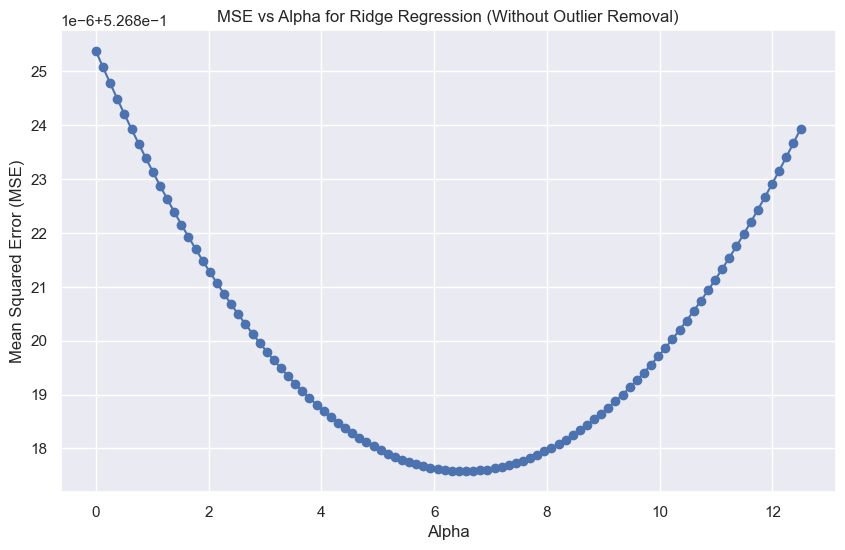

Best Alpha without outlier removal: 6.565656565656566
Resultados de la regresión lineal (sin limpieza de outliers):
Mean Squared Error (MSE): 0.5305677824766755
Mean Absolute Error (MAE): 0.5272474538305956

Resultados de la regresión Ridge (alpha=6.565656565656566 sin limpieza de outliers):
Mean Squared Error (MSE): 0.5304149219232502
Mean Absolute Error (MAE): 0.5272217082364


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

# Cargar los datos originales sin limpieza de outliers
california_housing = fetch_california_housing()
X = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
y = pd.Series(california_housing.target, name=california_housing.target_names[0])

# Dividir el dataset en conjunto de entrenamiento y prueba sin limpiar outliers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalado de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el rango de valores de alpha
alpha_values = np.linspace(0, 12.5, 100)

# Lista para almacenar los resultados de MSE para cada alpha
mse_values = []

# Realizar validación cruzada de 5-folds para cada valor de alpha
for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    cv = cross_val_score(ridge_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    mse = -cv.mean()
    mse_values.append(mse)
    print(f"La media del MSE en 5-fold CV para la regresión Ridge con alpha={alpha} es {mse}")
    print(f"El desvío estándar del MSE en 5-fold CV para la regresión Ridge con alpha={alpha} es {cv.std()}")

# Graficar el valor de MSE versus alpha
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, mse_values, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Alpha for Ridge Regression (Without Outlier Removal)')
plt.grid(True)
plt.show()

# Obtener el mejor valor de alpha
best_alpha = alpha_values[np.argmin(mse_values)]
print(f'Best Alpha without outlier removal: {best_alpha}')

# Crear y entrenar el modelo de regresión Ridge con el mejor alpha en datos escalados
best_ridge_model = Ridge(alpha=best_alpha)
best_ridge_model.fit(X_train_scaled, y_train)

# Evaluar el modelo de regresión Ridge en el set de prueba escalado
y_test_pred_ridge = best_ridge_model.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)

# Evaluar el modelo de regresión lineal en el set de prueba escalado
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_test_pred_lin = lin_reg.predict(X_test_scaled)
mse_lin = mean_squared_error(y_test, y_test_pred_lin)
mae_lin = mean_absolute_error(y_test, y_test_pred_lin)

# Imprimir los resultados
print(f'Resultados de la regresión lineal (sin limpieza de outliers):')
print(f'Mean Squared Error (MSE): {mse_lin}')
print(f'Mean Absolute Error (MAE): {mae_lin}')
print()
print(f'Resultados de la regresión Ridge (alpha={best_alpha} sin limpieza de outliers):')
print(f'Mean Squared Error (MSE): {mse_ridge}')
print(f'Mean Absolute Error (MAE): {mae_ridge}')


Observamos de igual manera que la diferencia es minima entre la regresión lineal y la regresión ridge.